$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# Reinforcement Learning to Control a Marble

Remember the one-dimensional maze example from last time.  

We can make our one-dimensional maze problem into a realistic control
problem by saying we have a marble on a one-dimensional track that has
a mass and real-valued position and velocity values.  So the state is
actually two-dimensional, position, $x$, and velocity,
$\dot{x}$. Actions are forces on the marble and let's just allow three
forces, $-1$, $0$, and $1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import neuralnetworksA4 as nn

As before, we define the ```reinforcement```, ```initialState```, and ```nextState``` functions to specify our dynamic marble problem.

In [3]:
from copy import copy

valid_actions = (-1, 0, 1)   # Possible actions

goal = 5

def reinforcement(s, s_next):
    # goal = 5
    # return 0 if abs(s_next[0] - goal) < 1 else -1
    return -abs(s_next[0] - goal)

def initial_state():
    global goal
    goal = np.random.randint(1, 10)  # 1, 2, 3, ... , 9
    return np.array([np.random.uniform(0, 10),
                     np.random.uniform(-2, 2), 
                     goal])

def next_state(s, a):
    s = copy(s)   # s[0] is position, s[1] is velocity. s[2] is goal, a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    
    # Bound next position. If at limits, set velocity to 0 for inelastic collision,
    # or to -s[1] for elastic collision
    if s[0] < 0:
        s = [0, -s[1], s[2]]
    elif s[0] > 10:
        s = [10, -s[1], s[2]]
        
    return s

We also need our ```epsilonGreedy``` function.

In [4]:
def epsilon_greedy(nnetQ, state, valid_actions, epsilon):
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        action = np.random.choice(valid_actions)
        
    else:
        
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
        ai = np.argmax(Qs)
        action = valid_actions[ai]
        
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

The ```makeSamples``` function is still general.  We modify the one from the previous notes just a bit to allow our state variable to contain multiple values.

In [5]:
def make_samples(nnet, initial_state_f, next_state_f, reinforcement_f,
                valid_actions, num_samples, epsilon):

    X = np.zeros((num_samples, nnet.n_inputs))
    R = np.zeros((num_samples, 1))
    Qn = np.zeros((num_samples, 1))

    s = initial_state_f()
    s = next_state_f(s, 0)        # Update state, sn from s and a
    a, _ = epsilon_greedy(nnet, s, valid_actions, epsilon)

    # Collect data from numSamples steps
    for step in range(num_samples):
        sn = next_state_f(s, a)        # Update state, sn from s and a
        rn = reinforcement_f(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilon_greedy(nnet, sn, valid_actions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

Like before, let's make a *plotStatus* function to show us how we are doing.

In [10]:
def plot_status(Qnet, trial, epsilon_trace, r_trace):
    
    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
               
    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    binSize = 5
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(r_trace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)), axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
        
    qs = Qnet.use(np.array([[s, 0, goal, a] for a in valid_actions for s in range(11)]))
               
    plt.subplot(3, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2,'Policy for Zero Velocity')
    plt.axis('off')
               
               
    plt.subplot(3, 3, 4)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = Qnet.use(np.array([[xsflat[i], ysflat[i], a, goal] for a in valid_actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(valid_actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax, 20, cmap='coolwarm')
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
               
    plt.subplot(3, 3, 5)
    acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap='coolwarm')
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    plt.subplot(3, 3, 6)
    plt.plot(X[:, 0], X[: ,1])
    plt.plot(X[-1, 0], X[-1, 1], 'ro')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.title('Last Trial')

    ax = plt.subplot(3, 3, 7, projection='3d')
    ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap='coolwarm')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    ax = plt.subplot(3, 3, 8, projection='3d')
    ax.plot_surface(xs, ys, acts, linewidth=0, cmap='coolwarm')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

And, let's write a function to plop the marble down at a number of positions and try to control it, plotting the results.

In [11]:
def test_it(Qnet, n_trials, n_steps_per_trial):
    global goal
    goal = np.random.randint(1, 10)

    xs = np.linspace(0, 10, n_trials)
    plt.subplot(3, 3, 9) 
    
    # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
    for x in xs:
        
        s = [x, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps_per_trial, 3))
        for step in range(n_steps_per_trial):
            a, _ = epsilon_greedy(Qnet, s, valid_actions, 0.0) # epsilon = 0
            s = next_state(s, a)
            x_trace[step, :] = s
            
        plt.plot(x_trace[:, 0], x_trace[:, 1])
        plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
        plt.fill_between([goal-1, goal+1], [-5, -5], [5, 5], color='pink', alpha=0.3)
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [12]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.X_means = np.array(Xmeans)
    Qnet.X_stds = np.array(Xstds)
    Qnet.T_means = np.array(Tmeans)
    Qnet.T_stds = np.array(Tstds)

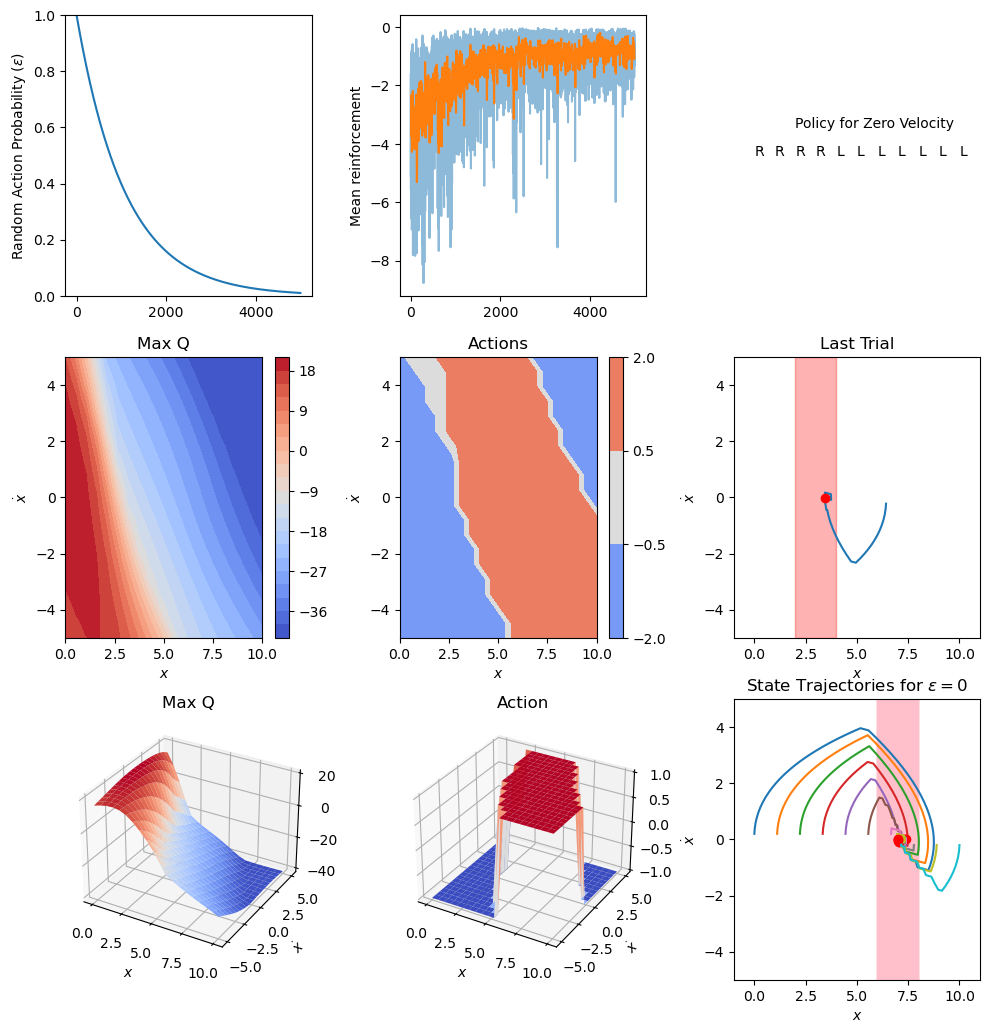

In [20]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8        # discount factor
n_trials = 5000        # number of repetitions of makeSamples-updateQ loop
n_steps_per_trial = 100 # number of steps between new random initial states
n_epochs = 20
final_epsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilon_decay =  np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value
# epsilon_decay = 0.9
print('epsilon_decay is',epsilon_decay)

nh = [20, 10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)

# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setup_standardization(nnetQ, [5, 0, 0, 5], [2, 2, 0.8, 2], [-5], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(n_trials)
rtrace = np.zeros(n_trials)

for trial in range(n_trials):
    
    # Collect nStepsPerRep samples of X, R, Qn 
    X, R, Qn = make_samples(nnetQ, initial_state, next_state, reinforcement, 
                            valid_actions, n_steps_per_trial, epsilon)
    # Update neural network using these samples
    nnetQ.train(X, R + gamma * Qn, n_epochs=n_epochs, method='scg', 
                learning_rate=0.01, verbose=False)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *=  epsilon_decay
    epsilon = max(final_epsilon, epsilon)
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == n_trials or trial % (n_trials / 10) == 0):
        fig.clf()
        plot_status(nnetQ, trial, epsilonTrace, rtrace)
        test_it(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

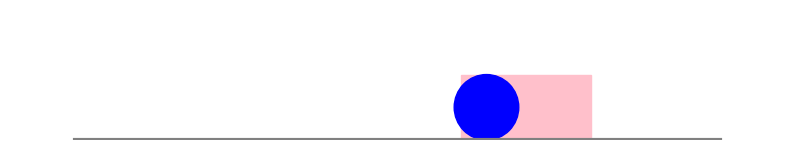

In [21]:
import matplotlib.patches as pltpa 
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10, 1.7))

for trial in range(10):
    x = np.random.uniform(0, 10)
    v = np.random.uniform(-4, 4)
    goal = np.random.uniform(2, 9)
    s = [x, v, goal] 
    for step in range(n_steps_per_trial):
        plt.clf()
        x = s[0]
        a, _ = epsilon_greedy(nnetQ, s, valid_actions, 0.0) # epsilon = 0
        plt.plot([0, 10], [0, 0], lw=3, color='gray')
        ax = fig.gca()
        ax.add_patch(pltpa.Rectangle((goal, 0), 2, 1, color='pink'))
        ax.add_patch(pltpa.Circle((x, 0.5), 0.5, color='blue'))
        if a != 0:
            plt.arrow(x, 0.5 , a * 0.4, 0., head_width=0.1, head_length=0.1,
                      color='yellow')
        plt.xlim(-1, 11)
        plt.ylim(0, 2)
        plt.axis('off')
        
        s = next_state(s, a)

        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)